# ``eBOSS`` Quasar Luminosity Function

Initiate notebook.

In [1]:
from pprint import pprint

import corner
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from astropy.cosmology import Planck15
from mpl_toolkits import mplot3d

from conf import PATH
from horizonground.lumfunc_likelihood import LumFuncMeasurements
from horizonground.lumfunc_modeller import (
    LumFuncModeller,
    quasar_PLE_model,
    quasar_hybrid_model,
)
from horizonground.utils import process_header

Define parameter ranges.

In [2]:
REDSHIFT_RANGE = 0., 3.
MAGNITUDE_RANGE = -29.0, -20.6
DENSITY_RANGE = pow(10, -9.225), pow(10, -4.775)

## ``eBOSS`` Luminosity function data

Load luminosity function data in redshift bins.

In [3]:
MEASUREMENTS_FILE = PATH/"external"/"eBOSS_QSO_LF_measurements.txt"
UNCERTAINTIES_FILE = PATH/"external"/"eBOSS_QSO_LF_uncertainties.txt"

luminosity_function_data = LumFuncMeasurements(
    MEASUREMENTS_FILE, UNCERTAINTIES_FILE, base10_log=False
)

## Luminosity function model

Specify luminosity function model.

In [4]:
modeller = LumFuncModeller.from_parameters_file(
    parameter_file="../data/external/eBOSS_QSO_LF_PLE_model_fits.txt",
    lumfunc_model=quasar_PLE_model,
    brightness_variable='magnitude',
    threshold_value=-21.80,
    threshold_variable='magnitude',
    cosmology=Planck15,
    base10_log=False,
)

luminosity_function_model = modeller.luminosity_function

Visualise luminosity function surface.

Text(0.5, 0, '$\\Phi(m,z)$ [$\\textrm{Mpc}^{-3} \\textrm{mag}^{-1}$]')

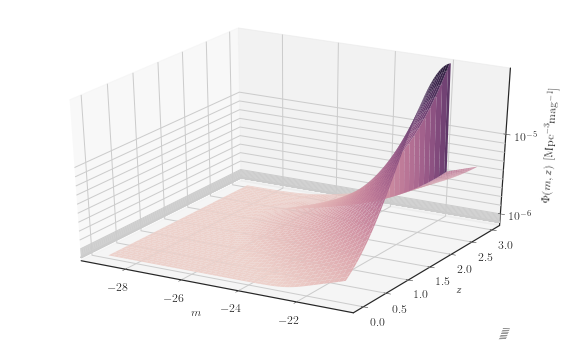

In [5]:
NUM_MESH = 100

magnitudes = np.linspace(*MAGNITUDE_RANGE, num=NUM_MESH, endpoint=False)
redshifts = np.linspace(*REDSHIFT_RANGE, num=NUM_MESH, endpoint=False)
m, z = np.meshgrid(magnitudes, redshifts)
Phi = luminosity_function_model(m, z)

fig = plt.figure("Luminosity function surface", figsize=(10, 6))
ax = plt.axes(projection='3d')

ax.plot_surface(
    m, z, Phi,
    cmap=sns.cubehelix_palette(as_cmap=True),
    edgecolor='none'
)

ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$z$")

ax.set_zlim(*DENSITY_RANGE)
ax.set_zscale('log')
ax.set_zticks([pow(10, -5), pow(10, -6)])
ax.set_zlabel(r"$\Phi(m,z)$ [$\textrm{Mpc}^{-3} \textrm{mag}^{-1}$]")

## ``eBoss`` quasar luminosity function results

Load sample MCMC chains and construct models from each sample point.

In [6]:
model_param_chain_file = (
    "../data/output/eBOSS_QSO_LF_PLE_zeus_1512631_32_5E5_by1.h5"
)

burnin, reduce = 10000, 10
with h5py.File(model_param_chain_file, 'r') as chain_data:
    chain = chain_data['mcmc']['chain']
    nparam = chain.shape[-1]
    chain_flat = chain[:, burnin::reduce, :].reshape((-1, nparam))

In [16]:
# corner.corner(
#     chain_flat, bins=160, smooth=0.45,
#     quantiles=[0.1587, 0.5, 0.8413],
#     levels=1.0-np.exp(-np.square([1, 2])/2),
#     quiet=True, rasterized=True, show_titles=True, label_kwargs={'visible': False},
#     plot_datapoints=False, plot_contours=True, fill_contours=True,
#     color="#A3C1AD", truth_color='#7851a9'
# )

with open("../data/input/cabinet/eBOSS_QSO_LF_PLE_model_fits.txt") as f:
    param_names = process_header(f.readline())

one_sigma_quantiles = np.asarray([
    corner.quantile(chain_flat[:, i], q=[0.1587, 0.8413])
    for i in range(nparam)
])

within_one_sigma_model = [
    model_point for model_point in chain_flat
    if np.all(model_point > one_sigma_quantiles[:, 0])
    and np.all(model_point < one_sigma_quantiles[:, 1])
]

within_one_sigma_luminosity_function = [
    LumFuncModeller(
        lumfunc_model=quasar_PLE_model,
        brightness_variable='magnitude',
        threshold_value=-21.80,
        threshold_variable='magnitude',
        cosmology=Planck15,
        base10_log=False,
        **dict(zip(param_names, model_point.tolist()))
    ).luminosity_function
    for model_point in within_one_sigma_model
]

In [19]:
print(len(within_one_sigma_model)/len(chain_flat))
print(dict(zip(param_names, within_one_sigma_model[0].tolist())))

0.17005229591836735
{'M_{g\\ast}(z_\\textrm{p})': -26.73874906329136, '\\Delta{M_{g\\ast}(z_\\textrm{p})}': -5.920425591504357, '\\lg\\Phi_\\ast': -4.490169363765116, '\\Delta\\lg\\Phi_\\ast': -2.795014231300763, '\\alpha_\\textrm{l}': -1.4953609862430375, '\\Delta\\alpha_\\textrm{l}': -1.2553003794763549, '\\alpha_\\textrm{h}': -0.10923589038969057, '\\Delta\\alpha_\\textrm{h}': -0.47641624226472473, '\\beta_\\textrm{l}': -0.4760106892629919, '\\Delta\\beta_\\textrm{l}': 0.10036660196844444}


In [18]:
NUM_INTERVALS = 100

NUM_ROW, NUM_COL = 2, 4
ROW_SPAN, COL_SPAN = 4, 3

LEGEND_SETTINGS = dict(
    loc='upper left',
    handlelength=1.2, 
    handletextpad=0.5
)

m = np.linspace(*MAGNITUDE_RANGE, num=NUM_INTERVALS+1)

magnitude_bins = luminosity_function_data.brightness_bins
redshift_bins = luminosity_function_data.redshift_bins
redshift_labels = luminosity_function_data.redshift_labels

plt.figure("eBOSS QSO Luminosity Function", figsize=(12, 8))
for bin_idx, redshift in enumerate(redshift_bins):
    
    row_idx, col_idx = bin_idx // NUM_COL, bin_idx % NUM_COL
    
    ax = plt.subplot2grid(
        (NUM_ROW * ROW_SPAN, NUM_COL * COL_SPAN), 
        (row_idx * ROW_SPAN, col_idx * COL_SPAN), 
        rowspan=ROW_SPAN, colspan=COL_SPAN
    )
        
    data_values, data_errors = luminosity_function_data[bin_idx]
    
    if bin_idx == 0:
        plt.errorbar(
            magnitude_bins, data_values, data_errors,
            fmt='o', markersize=4., capsize=0.,
            label='measurements'
        )
        for idx, luminosity_function_model in enumerate(within_one_sigma_luminosity_function):
            if idx == 0:
                plt.plot(m, luminosity_function_model(m, redshift), label='PLE model')
            else:
                plt.plot(m, luminosity_function_model(m, redshift))
        plt.legend(**LEGEND_SETTINGS)
    else:
        plt.errorbar(
            magnitude_bins, data_values, data_errors,
            fmt='o', markersize=4., capsize=0.
        )
        for luminosity_function_model in within_one_sigma_luminosity_function:
            plt.plot(m, luminosity_function_model(m, redshift))
    plt.xscale('linear')
    plt.xlim(*MAGNITUDE_RANGE)
    
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
    if row_idx + 1 < NUM_ROW:
        plt.tick_params(
            axis='x', which='both', direction='in', 
            labelbottom=False, labelsize=2
        )
    else:
        plt.xlabel(r"$M_{g,z=2}$")
        
    plt.yscale('log')    
    plt.ylim(*DENSITY_RANGE)
    
    if col_idx > 0:
        plt.tick_params(
            axis='y', which='both', direction='in',
            labelleft=False, labelsize=2
        )
    else:
        plt.ylabel(r"$\Phi$ [$\textrm{Mpc}^{-3} \textrm{mag}^{-1}$]")
    
    plt.title(
        redshift_labels[bin_idx], loc='right', position=(0.925, 0.025)
    )

plt.subplots_adjust(hspace=0, wspace=0)

KeyError: 'k_{1\\textrm{l}}'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7ff47d1b4200> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'$\\\\times\\\\mathdefault{10^{-6}}\\\\mathdefault{}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode
(/home/mikew/.cache/matplotlib/tex.cache/4186c37df038e0f1eb271c5a056dc9db.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, ru
ssian, ukrainian, bulgarian, loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./4186c37df038e0f1eb271c5a056dc9db.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.14 ...}{15.000000}{\rmfamily $\times\mathdefault
                                                  {10^{-6}}\mathdefault{}$}
No pages of output.
Transcript written on 4186c37df038e0f1eb271c5a056dc9db.log.




RuntimeError: latex was not able to process the following string:
b'$\\\\times\\\\mathdefault{10^{-6}}\\\\mathdefault{}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode
(/home/mikew/.cache/matplotlib/tex.cache/4186c37df038e0f1eb271c5a056dc9db.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, ru
ssian, ukrainian, bulgarian, loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./4186c37df038e0f1eb271c5a056dc9db.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.14 ...}{15.000000}{\rmfamily $\times\mathdefault
                                                  {10^{-6}}\mathdefault{}$}
No pages of output.
Transcript written on 4186c37df038e0f1eb271c5a056dc9db.log.




<Figure size 864x576 with 1 Axes>